# TDAチュートリアル1：TDA用OSS GUDHIの基本的な使い方

ここではフランスの研究機関Inriaが中心となって開発されているTDA用のOSS GUDHIの基本的な使い方を解説する．GUDHIは点群やその他のデータからフィルトレーションを作り，そこからパーシステンス図を構成して可視化するという機能を持つ．またパーシステンス図をベクトル化する機能も有しており，scikit-learnを始めとする機械学習ライブラリと組み合わせることも可能である．

このノートでは点群からフィルトレーションを作りパーシステンス図を可視化するところまでを説明する．

## インストール

GUDHIはpipでインストール（あるいはcondaでインストール）が可能である．インストールには以下のコマンドを実行すれば良い．

In [ ]:
!pip install gudhi==3.4.1

## 単純な点群からフィルトレーション作成・パーシステンス図出力まで

点群からフィルトレーションを作るやり方について説明する．

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import gudhi
# %matplotlib notebook

まず単純な点でフィルトレーションの作り方を見てみる．

In [3]:
X0 = np.array([[0,0], [1,0], [0,1], [1,1]])

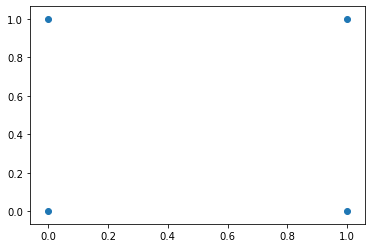

In [4]:
plt.scatter(X0[:,0],X0[:,1])
plt.show()

典型的なフィルトレーションはVietoris-Ripsフィルトレーション（または単にRipsフィルトレーション）である．これを作るにはクラス`RipsComplex`をつかってフィルトレーションをどのように構成するのかを指定してから，単体複体やフィルトレーションの構造をあらわすクラス`SimplexTree`に変換すれば良い．メソッド`create_simplex_tree`にどの次元までの単体を考えるかの引数を与えて`SimplexTree`を作ることができる．

In [5]:
rips0 = gudhi.RipsComplex(X0)
st0 = rips0.create_simplex_tree(2)

ここでできた`SimplexTree`が点群から作ったRipsフィルトレーションの情報を持っている．ここからパーシステンス図を取り出すにはメソッド`persistence`を用いる．

In [6]:
diag0 = st0.persistence()

GUDHIはパーシステンス図をタプルのリストで表示する．各タプルの第0成分が何次元の「穴」であるか（ホモロジーの次元）をあらわし，第1成分がパーシステンス図の点の座標，すなわち生成・消滅時刻の組をあらわす．

In [7]:
diag0

[(1, (1.0, 1.4142135623730951)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

パーシステンス図を可視化するには`plot_persistence_diagram`を用いればよい．グラフィカルな表示としては全ての次元の「穴」（ホモロジー類）に関する生成・消滅時刻が2次元空間にプロットされ，色でその次元があらわされている．

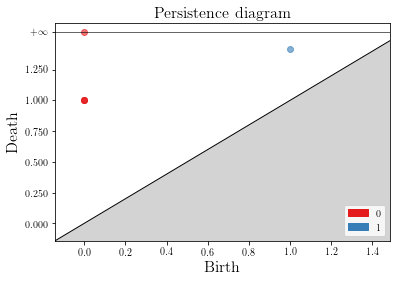

In [8]:
gudhi.plot_persistence_diagram(diag0, legend=True)

`plot_persistence_barcode`を用いることでバーコードとして表示することもできる．

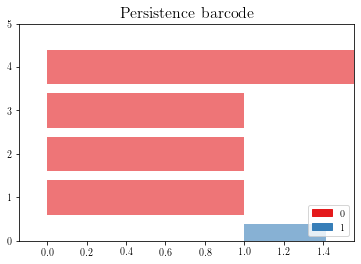

In [9]:
gudhi.plot_persistence_barcode(diag0, legend=True)

もう少し意味のある点群のパーシステンス図を出力してみる．最初は引き続き2次元内の点群について考えよう．

In [10]:
def generate_random_line(num_pts):
    pts = np.vstack([np.random.uniform(-1,1,num_pts), np.zeros(num_pts)]).T
    return pts
    
def generate_random_circle(num_pts):
    X = np.random.randn(num_pts, 2)
    norms = np.linalg.norm(X, axis=1)
    pts = X / norms.reshape(num_pts, -1)
    return pts

In [11]:
num_pts = 100
X_line = generate_random_line(num_pts)
X_circle = generate_random_circle(num_pts)

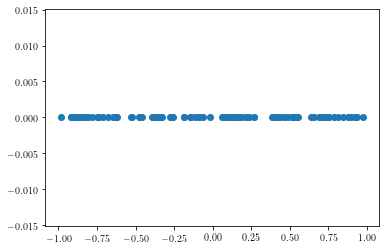

In [12]:
plt.scatter(X_line[:,0], X_line[:,1])
plt.show()

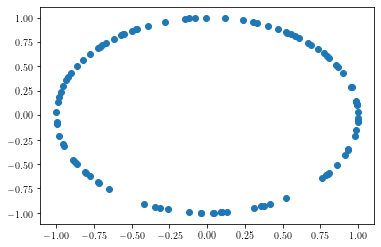

In [13]:
plt.scatter(X_circle[:,0], X_circle[:,1])
plt.show()

In [14]:
rips_line = gudhi.RipsComplex(X_line)
st_line = rips_line.create_simplex_tree(2)
diag_line = st_line.persistence()

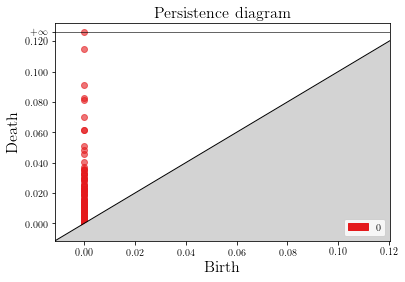

In [15]:
gudhi.plot_persistence_diagram(diag_line, legend=True)

In [16]:
rips_circle = gudhi.RipsComplex(X_circle)
st_circle = rips_circle.create_simplex_tree(2)
diag_circle = st_circle.persistence()

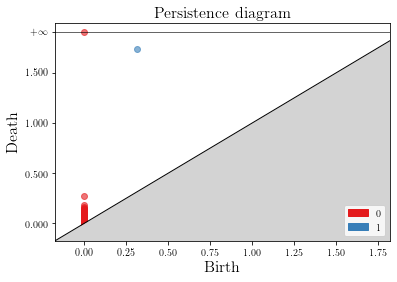

In [17]:
gudhi.plot_persistence_diagram(diag_circle, legend=True)

パーシステンス図の出力を見ると，線分の方は1次の「穴」に対応する点がないが円周の方は1次の「穴」に対応する対角線から離れた点が一点存在することが分かる．

次に3次元空間内の点群についてもパーシステンス図を出力してみよう．

In [18]:
def generate_random_plane(num_pts):
    pts = np.vstack([np.random.uniform(-1,1,num_pts), np.random.uniform(-1,1,num_pts), np.zeros(num_pts)]).T
    return pts

def generate_random_sphere(num_pts):
    X = np.random.randn(num_pts, 3)
    norms = np.linalg.norm(X, axis=1)
    pts = X / norms.reshape(num_pts, -1)
    return pts

In [19]:
num_pts = 1000
X_plane = generate_random_plane(num_pts)
X_sphere = generate_random_sphere(num_pts)

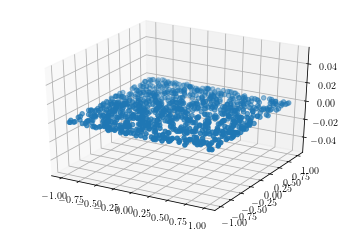

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_plane[:,0],X_plane[:,1],X_plane[:,2])
plt.show()

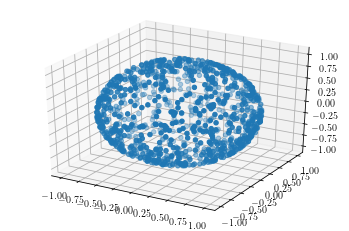

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_sphere[:,0],X_sphere[:,1],X_sphere[:,2])
plt.show()

これらのパーシステンス図を出力してみたいが，上で説明したRipsフィルトレーションを使って計算しようとすると重くて計算が終わらない（実際に試してみよ）．これを回避するために代わりにアルファフィルトレーション`AlphaComplex`を用いることができる．

In [22]:
alpha_plane = gudhi.AlphaComplex(X_plane)
st_plane = alpha_plane.create_simplex_tree(3)
diag_plane = st_plane.persistence()

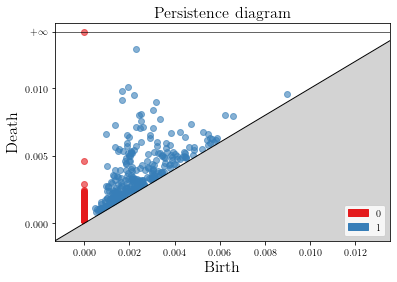

In [23]:
gudhi.plot_persistence_diagram(diag_plane, legend=True)

In [24]:
alpha_sphere = gudhi.AlphaComplex(X_sphere)
st_sphere = alpha_sphere.create_simplex_tree(3)
diag_sphere = st_sphere.persistence()

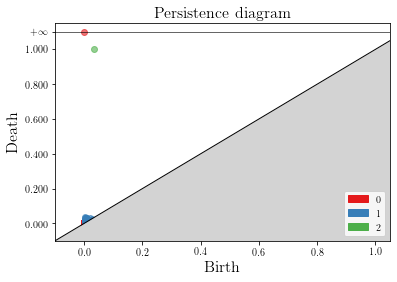

In [25]:
gudhi.plot_persistence_diagram(diag_sphere, legend=True)

上の結果を見ると球面の方には対角線から遠くに2次元の「穴」が存在していることが分かり，TDAを使って点群を「形」の観点からも区別できることが分かる．

ちなみに上のパーシステンス図のように点が多く見づらい場合は`plot_persistence_density`を使ってパーシステンス図を分布の形で可視化することもできる．

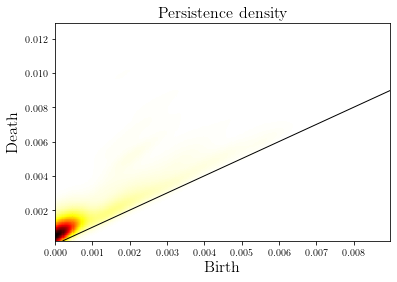

In [26]:
gudhi.plot_persistence_density(diag_plane)